# A) Pendahuluan

Pengolahan ini menggunakan kernel ais-tt atau saat ini: pyspark3.3 ais2.8 untuk melakukan pengolahan data. Kernel ini dilengkapi dengan konfigurasi spark tambahan dan kredensial untuk Amazon Web Services (AWS).

In [ ]:
#Impor package
import sedona.sql
from sedona.register import SedonaRegistrator
from sedona.utils import SedonaKryoRegistrator, KryoSerializer
from sedona.core.SpatialRDD import PolygonRDD, PointRDD
from sedona.core.enums import FileDataSplitter

import pyspark.sql.functions as F
import pyspark.sql.types as T
import pyspark.sql.types as pst
from pyspark.sql.functions import lit
import pyspark.sql
from pyspark.sql.dataframe import DataFrame
from pyspark import StorageLevel
from pyspark.sql import SparkSession
from pyspark.sql.window import Window
from pyspark.sql.types import IntegerType,LongType,StringType

###Packages within Kernel by default
import geopandas as gpd
import h3
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib as mpl
from shapely.ops import transform
from shapely.geometry import Polygon
from datetime import datetime
import requests
import pandas as pd
import numpy as np
import string
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
import requests

In [ ]:
#aktivasi spark session
spark = SparkSession. \
    builder. \
    appName('Emissions_Indonesia'). \
    config("spark.serializer", KryoSerializer.getName). \
    config("spark.kryo.registrator", SedonaKryoRegistrator.getName). \
    config('spark.jars.packages'). \
    config("spark.sql.execution.arrow.pyspark.enabled", "true").\
    config("spark.sql.parquet.enableVectorizedReader", "false").\
    getOrCreate()

SedonaRegistrator.registerAll(spark)

/opt/spark/python/lib/pyspark.zip/pyspark/sql/context.py:112: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.


Closing down clientserver connection


True

# B) Read Data AIS di AWS S3 Bucket

In [ ]:
save_path = "s3a://ungp-ais-data-historical-backup/user_temp/"
save_path_unique = save_path + "212112081/"
#read saved parquet
data = spark.read.parquet(save_path_unique + "ais-ihs-indonesia-2021_FULL.parquet", header=True)

# C) Konversi Tipe Kapal ke Water Transport (NACE H50) dan Assign Residensi

In [ ]:
#Ambil data dari GitHub
convert_IHS = "https://raw.githubusercontent.com/GunturFai/ais-stis/main/Activities_Fix_1.csv"
convert_IHS = pd.read_csv(convert_IHS, sep=";")
convert_IHS = spark.createDataFrame(convert_IHS)
convert_IHS = convert_IHS.select("StandardVesselType", "ShiptypeLevel5", "Classif")
convert_IHS.printSchema()

root
 |-- StandardVesselType: string (nullable = true)
 |-- ShiptypeLevel5: string (nullable = true)
 |-- Classif: string (nullable = true)



/opt/spark/python/lib/pyspark.zip/pyspark/sql/pandas/conversion.py:604: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.


In [ ]:
#Left Join berdasarkan ShipTypeLevel5
from pyspark.sql.functions import col
data = data.join(convert_IHS.select("ShiptypeLevel5", "Classif"), on="ShipTypeLevel5", how="left")
#data.printSchema()

In [ ]:
#Filter data yang termasuk pada aktivitas ISIC 501 berdasarkan ShipTypeLevel5
data_filtered = data.filter(col("Classif").isin("ISIC 501","Fishing","Military"))

Rename Residensi
1.   Jika type = "res di luar" maka variabel Residensi memiliki nilai "Residen di Luar Teritory"
2.   Jika type = "res nonres di dalam" maka ada dua hal
*   Jika OperatorCountryofDomicile = Indonesia maka variabel Residensi = "Residen di Teritori"
*   Jika OperatorCountryofDomicile = Selain Indonesia maka variabel Residensi = "Nonresiden di Teritori"



In [ ]:
from pyspark.sql.functions import when

# Menambahkan variabel Residensi berdasarkan kondisi type dan OperatorCountryofDomicile
data = data_filtered.withColumn("Residensi",
     when(col("tipe") == "res di luar", "Residen di Luar Teritory")
    .when((col("tipe") == "res nonres di dalam") & (col("OperatorCountryofDomicileName") == "Indonesia"), "Residen di Teritori")
    .when((col("tipe") == "res nonres di dalam") & (col("OperatorCountryofDomicileName") != "Indonesia"), "Nonresiden di Teritori")
)

In [ ]:
#Jumlah Record
data.groupBy(col("Residensi")).count().show()

+--------------------+---------+
|           Residensi|    count|
+--------------------+---------+
|Nonresiden di Ter...|109325955|
| Residen di Teritori| 38005070|
|Residen di Luar T...| 12592506|
+--------------------+---------+



# D) Koreksi Pengambilan Pesan serta Penghitungan Pesan, Filter Kapal yang diasumsikan Tidak Aktif, Penghapusan Pesan Dengan Durasi > 4 Jam, serta Penghitungan Jumlah Kapal


### Koreksi pengambilan pesan

In [ ]:
h3_perluasan = spark.read.parquet(save_path_unique + "h3_index_level5_perluasan.parquet", header=True)
data_inner = data.filter(data['Residensi'] != 'Residen di Luar Teritory')
#Inner Join untuk mendapat data yang match
data_matched_inner = data_inner.join(h3_perluasan, data_inner.H3_int_index_5 == h3_perluasan.h3_index, "inner")

In [ ]:
data_matched_inner.count()

53596497

In [ ]:
data_matched_inner.filter(data_matched_inner['Residensi'] == 'Residen di Teritori').count()

1242347

In [ ]:
#Tambahan data residen di daerah perluasan 5% sebagai residen di luar teritori
tambahan_res_out = data_matched_inner.filter(data_matched_inner['Residensi'] == 'Residen di Teritori')
tambahan_res_out = tambahan_res_out.drop('h3_index')
data_resout = data.filter(data['Residensi'] == 'Residen di Luar Teritory')
data_residen_outside_corrected = data_resout.union(tambahan_res_out)

In [ ]:
#subtraksi data residen di teritori dengan data residen di daerah perluasan 5% agar hanya residen di dalam ZEE di dataset
data_residen_inside = data.filter(data['Residensi'] == 'Residen di Teritori')
data_residen_inside_corrected = data_residen_inside.subtract(tambahan_res_out)

In [ ]:
#dapatkan record nonresiden di daerah perluasan 5%
data_nonresiden_di1perc = data_matched_inner.filter(data_matched_inner['Residensi'] == 'Nonresiden di Teritori')
data_nonresiden_di1perc = data_nonresiden_di1perc.drop('h3_index')
#subtraksi data nonresiden di teritori dengan data nonresiden di perluasan 5% agar hanya nonresiden di dalam ZEE di dataset
data_nonresiden_inside = data.filter(data['Residensi'] == 'Nonresiden di Teritori')
data_nonresiden_corrected = data_nonresiden_inside.subtract(data_nonresiden_di1perc)

In [ ]:
#Gabungkan seluruh data yang sudah dikoreksi
data_residen_outside_corrected = data_residen_outside_corrected.withColumn("newres", lit("Residen Outside"))
data_residen_inside_corrected  = data_residen_inside_corrected.withColumn("newres", lit("Residen Inside"))
data_nonresiden_corrected = data_nonresiden_corrected.withColumn("newres", lit("Nonresiden Inside"))

In [ ]:
dataunion1 = data_residen_outside_corrected.union(data_residen_inside_corrected)
dataunion2 = dataunion1.union(data_nonresiden_corrected)
#hitung jumlah pesan untuk data yang sudah dikoreksi
dataunion2.groupBy(col("newres")).count().show()

+-----------------+--------+
|           newres|   count|
+-----------------+--------+
|   Residen Inside|36762723|
|  Residen Outside|13834853|
|Nonresiden Inside|56971805|
+-----------------+--------+



### Filter Kapal yang Diasumsikan Tidak Aktif serta Penghapusan Pesan dengan Durasi > 4 Jam

In [ ]:
cnt_cond = lambda cond: F.sum(F.when(cond, 1).otherwise(0))

imo_filter = dataunion2.groupBy("imo")\
                .agg(F.count('dt_pos_utc').alias("count_ais"),
                    cnt_cond(F.col('sog') > 3). alias("count_min_sog"))\
                .where((F.col('count_ais') < 10)|(F.col('count_min_sog') < 20))\
                .select("imo")

## jumlah kapal yang tidak aktif
#imo_filter.count()
imo_filter_list = imo_filter.select("imo")

#pesan dengan kapal diasumsikan  aktif
df_filter = dataunion2.join(imo_filter_list, "imo", "left_anti")

In [ ]:
#pesan dengan kapal yang diasumsikan tidak aktif
kapal_tidak_aktif = dataunion2.join(imo_filter_list, "imo", "inner")
kapal_tidak_aktif.count()

4441

In [ ]:
#Pesan lebih dari 4 jam
data_more4 = df_filter.filter(F.col("freq")>=4)
data_more4.count()

603346

In [ ]:
data_less4 = df_filter.filter(F.col("freq")<4)

## Penghitungan Jumlah Kapal

In [ ]:
#union dulu
map_vessel_type = "https://raw.githubusercontent.com/nandyarz/ais/main/map_vessel_type_imo4.json"
map_vessel_type = spark.createDataFrame(pd.read_json(map_vessel_type))

df_merged = data_less4.alias("a").join(
    map_vessel_type.alias("b"),
    F.col("a.ShiptypeLevel5") == F.col("b.ShiptypeLevel5"),
    "left").select( "a.*", "b.StandardVesselType")

/opt/spark/python/lib/pyspark.zip/pyspark/sql/pandas/conversion.py:604: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.


In [ ]:
#Jumlah Kapal per tipe Kapal
vessel_count = (
    df_merged.groupBy("StandardVesselType")
    .agg(F.countDistinct("imo").alias("total_vessels")))
vessel_count.show(19)

+--------------------+-------------+
|  StandardVesselType|total_vessels|
+--------------------+-------------+
|        Bulk carrier|         8255|
|Other liquids tan...|            6|
| Miscellaneous-other|          131|
|              Cruise|           50|
|Miscellaneous-fis...|           70|
|      Ferry-pax only|          175|
|               Ro-Ro|          225|
|       General cargo|          183|
|Liquified gas tanker|         1069|
|   Refrigerated bulk|          204|
|         Ferry-RoPax|            2|
|           Container|         2520|
|     Chemical tanker|         2121|
|             Vehicle|          529|
|          Oil tanker|         3228|
+--------------------+-------------+



In [ ]:
#jumlah kapal per tipe residen
datakapal = data_nonresiden_corrected.union(data_residen_inside_corrected)

cnt_cond = lambda cond: F.sum(F.when(cond, 1).otherwise(0))

imo_filter_kapal = datakapal.groupBy("imo")\
                .agg(F.count('dt_pos_utc').alias("count_ais"),
                    cnt_cond(F.col('sog') > 3). alias("count_min_sog"))\
                .where((F.col('count_ais') < 10)|(F.col('count_min_sog') < 20))\
                .select("imo")
imo_filter_list_kapal = imo_filter_kapal.select("imo")

#pesan dengan kapal diasumsikan  aktif
df_filter_kapal = datakapal.join(imo_filter_list_kapal, "imo", "left_anti")
df_filter_kapal_aktif = df_filter_kapal.filter(F.col("freq")<4)
df_merged_kapal = df_filter_kapal_aktif.alias("a").join(
    map_vessel_type.alias("b"),
    F.col("a.ShiptypeLevel5") == F.col("b.ShiptypeLevel5"),
    "left").select( "a.*", "b.StandardVesselType")
vessel_count_res = (
    df_merged_kapal.groupBy("StandardVesselType","newres")
    .agg(F.countDistinct("imo").alias("total_vessels")))

In [ ]:
vessel_count_res.show(35)

+--------------------+-----------------+-------------+
|  StandardVesselType|           newres|total_vessels|
+--------------------+-----------------+-------------+
|   Refrigerated bulk|   Residen Inside|            1|
|     Chemical tanker|   Residen Inside|          173|
|          Oil tanker|   Residen Inside|          446|
|Other liquids tan...|   Residen Inside|            2|
|Liquified gas tanker|   Residen Inside|           81|
|               Ro-Ro|Nonresiden Inside|           55|
|Miscellaneous-fis...|   Residen Inside|           34|
|       General cargo|Nonresiden Inside|           72|
|               Ro-Ro|   Residen Inside|          168|
|       General cargo|   Residen Inside|          111|
|Other liquids tan...|Nonresiden Inside|            4|
|      Ferry-pax only|Nonresiden Inside|           35|
|           Container|   Residen Inside|          181|
|             Vehicle|Nonresiden Inside|          510|
|     Chemical tanker|Nonresiden Inside|         1933|
|        B

# E) Preprocessing data IHS

In [ ]:
## mendapatkan kapal unik
datanew = data_less4
datanew = datanew.na.drop(subset=["OperatorCountryofDomicileName"])
unique_vessel = datanew.dropDuplicates(["imo"])

#### 1) Pengecekan Nilai Null dan 0 pada sampel pesan (5%)

In [ ]:
# Menampilkan banyaknya nilai null dan 0
from pyspark.sql import functions as F

# Sampel 5% dari datanew
columns = ['Powerkwmax', 'Speed', 'Speedmax', 'SummerDraught', 'MainEngineRPM', 'sog', 'draught']
sampled_df = datanew.sample(fraction=0.05, seed=42)

# Menghitung jumlah null dan 0 untuk setiap kolom secara terpisah
result = sampled_df.select(*[
        F.count(F.when(F.col(c).isNull(), 1)).alias(f"{c}_null")  # Hitung nilai null
        for c in columns] +
    [
        F.count(F.when(F.col(c) == 0, 1)).alias(f"{c}_zero")  # Hitung nilai 0
        for c in columns])
# Tampilkan hasilnya
result.show(vertical=True)

-RECORD 0---------------------
 Powerkwmax_null    | 876     
 Speed_null         | 0       
 Speedmax_null      | 0       
 SummerDraught_null | 0       
 MainEngineRPM_null | 156365  
 sog_null           | 0       
 draught_null       | 0       
 Powerkwmax_zero    | 14200   
 Speed_zero         | 289479  
 Speedmax_zero      | 2821866 
 SummerDraught_zero | 78055   
 MainEngineRPM_zero | 0       
 sog_zero           | 1634985 
 draught_zero       | 163871  



#### 2) Penyesuaian Spesifikasi Kapal Sesuai IMO GHG 4

In [ ]:
headers = {'User-Agent': 'XY'}

map_vessel_type = "https://raw.githubusercontent.com/nandyarz/ais/main/map_vessel_type_imo4.json"
map_vessel_type = pd.read_json(map_vessel_type)

#Types Table
vessel_type = "https://raw.githubusercontent.com/nandyarz/ais/main/type_table.json"
vessel_type = pd.read_json(vessel_type)

#####Functions--------------------
##Cleaning punctuations from new ais_types
def clean_string(text):
    text=''.join([word for word in text if word not in string.punctuation])
    text=text.lower()

    return text

##base shiptypelevel5 to comapre to
base_stype=map_vessel_type.ShiptypeLevel5.unique().tolist()

##Compare similiraty higher than 50% and return respective shiptype5 value
def compare_similarity(text):
    comp=[text]+base_stype
    cleaned=list(map(clean_string,comp))
    vectors=CountVectorizer().fit_transform(cleaned)
    vectors=vectors.toarray()
    csim=cosine_similarity(vectors)

    val_com=np.max(csim[0,1:])

    if val_com>0.75:
        v_type=base_stype[np.argmax(csim[0,1:])]
    else:
        v_type=None

    return v_type

##Imo bin finder
def bin_finder(vessel_t,value,df_in):
    try:
        bin_imo=df_in[((df_in.StandardVesselType==vessel_t)&(df_in.mindiff<=value)&(df_in.maxdiff>=value))].imo4bin.iloc[0]
    except:
        bin_imo=0
    return bin_imo

def ihs_preprocessing(df):
    columns = ['Powerkwmax', 'Speed', 'Speedmax', 'SummerDraught', 'MainEngineRPM']

    for c in columns:
        df[c].replace(0, np.nan, inplace=True)
        df[c]=df.groupby(["StandardVesselType", "imobin"])[c].apply(lambda x:x.fillna(x.mean()))
    return df

###++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
###Unit of cargo measurement per vessel type
unit={'Bulk carrier':'Deadweight',
     'Chemical tanker':'Deadweight',
     'Container':"TEU",
     'General cargo':'Deadweight',
     'Liquified gas tanker':'GrossTonnage',
     'Oil tanker':'Deadweight',
     'Other liquids tankers':'Deadweight',
     'Ferry-pax only':'GrossTonnage',
     'Cruise':'GrossTonnage',
     'Ferry-RoPax':'GrossTonnage',
     'Refrigerated bulk':'Deadweight',
     'Ro-Ro':'Deadweight',
     'Vehicle':'GrossTonnage',
     'Yacht':'GrossTonnage',
     'Service-tug':'GrossTonnage',
     'Miscellaneous-fishing':'GrossTonnage',
     'Offshore':'GrossTonnage',
     'Service-other':'GrossTonnage',
     'Miscellaneous-other':'GrossTonnage'}

##Engine type allocation
oil_eng=['Diesel-Elec & Gas Turbine(s)','Oil Engs & Fuel Cell-Electric''Oil Eng(s), Elec-Dr, Aux Sail','Oil Engines, Geared & Elec. Dr','Oil Eng(s) & Gas Turb(s) El.Dr','Oil Eng(s) Direct Dr, Aux Sail','Oil Eng(s) Dd & Gas Turb(s) El','Oil Engines, F&S, Geared Drive','Oil Engines, Direct & Elec. Dr','Oil Engines, Elec. & Direct Dr','Oil Engine(s), Drive Unknown','Oil Engines, Elec. & Geared Dr','Oil Eng(s), Geared, Aux Sail','Oil Engs & Gas Turb(s), Geared','Oil Engine(s), Electric Drive','Oil Engine(s), Direct Drive','Oil Engine(s), Geared Drive']
sail=['Sail, Aux Petrol Eng(s) D.Dr.','Sail, Aux Oil Eng(s), Elec Dr.','Sail, Aux Oil Eng(s), Geared','Sail','Sail, Aux Oil Eng(s) Direct-Dr',]
gas_tur=['Gas Turbine(s), Electric Drive','Gas Turbine(s) Or Diesel Elec.','Gas Turbine(s) & Diesel Elec.','Gas Turbine(s), Geared Drive',]
steam=['S.Turb, Gear & Oil Eng(s), Ele','St. Turb(s) Elec Dr. Or D.E.','Steam Turbine(s), Direct Drive','Steam Recip(s) With Lp Turbine','Steam Turbine(s), Elec.Drive','Steam- & Gas-Turbines, Geared','Steam Turbine(s), Geared Drive','Steam Recip(s), Direct Drive',]


def adapted_specs_imo(df_unique_imo):
    df_unique_imo.rename(columns={"vessel_type_main":"ais_type","length":"ais_loa","width":"ais_beam"},inplace=True)

    ind=df_unique_imo.copy()

    ind=ind.assign(ShiptypeLevel5=np.where(ind.ShiptypeLevel5.isnull(),ind.ais_type,ind.ShiptypeLevel5))
    ##Remove values with Shiptypelevel5 null. Not much else to do with this records.
    ##Remove nans before similarity check
    ind=ind[ind.ShiptypeLevel5.notnull()]
    ind=ind.assign(ShiptypeLevel5=np.where(ind.ShiptypeLevel5.isin(base_stype),ind.ShiptypeLevel5,
                                           ind.ShiptypeLevel5.apply(lambda x: compare_similarity(x))))
    ##Ensure no vessel without Standard vessel type
    ind=ind[ind.ShiptypeLevel5.notnull()]

    ##---Pending----Inputation here input from AIS(Length,Beam) and Shiptypelevel5 to have [DWT,GT]. Potential RF Regressor (missForest).

    ind=pd.merge(ind,map_vessel_type,how="left",on='ShiptypeLevel5')

    ind=ind.assign(imobin=ind.apply(lambda x: bin_finder(x.StandardVesselType,x[unit[x.StandardVesselType]],vessel_type),axis=1))

    ind=ihs_preprocessing(ind)

    ###Fuel allocation
    ind=ind.assign(fuel=np.where(((ind.FuelType1First=='Residual Fuel')|(ind.FuelType2Second=='Residual Fuel')),
                                np.where(((ind.PropulsionType.isin(['Steam Turbine(s), Geared Drive','S.Turb, Gear & Oil Eng(s), Ele','Steam Recip(s), Direct Drive','Steam- & Gas-Turbines, Geared','Steam Turbine(s), Elec.Drive','Steam Recip(s) With Lp Turbine','Steam Turbine(s), Direct Drive','St. Turb(s) Elec Dr. Or D.E.',]))\
                                                                &(ind.StandardVesselType=='Liquified gas tanker')),"LNG","HFO"),
                                    np.where(((ind.FuelType1First=='Distillate Fuel')&(ind.FuelType2Second=='Distillate Fuel')),"MDO",
                                    np.where(((ind.FuelType1First=='Distillate Fuel')&(ind.FuelType2Second.isin(['Yes, But Type Not Known','Not Applicable','Unknown',None]))),"MDO",
                                    np.where(((ind.FuelType1First.isin(['Yes, But Type Not Known','Not Applicable','Unknown',None]))&(ind.FuelType2Second=='Distillate Fuel')),"MDO",
                                    np.where(((ind.FuelType1First=='Coal')&(ind.FuelType2Second=='Distillate Fuel')),"MDO",
                                    np.where(((ind.FuelType1First=='Methanol')&(ind.FuelType2Second=='Distillate Fuel')),'Methanol',
                                        np.where((((ind.FuelType1First=='Residual Fuel')|(ind.FuelType2Second=='Residual Fuel'))&\
                                                ((ind.StandardVesselType=='Liquified gas tanker')&(ind.PropulsionType.isin(['Steam Turbine(s), Geared Drive','S.Turb, Gear & Oil Eng(s), Ele','Steam Recip(s), Direct Drive','Steam- & Gas-Turbines, Geared','Steam Turbine(s), Elec.Drive','Steam Recip(s) With Lp Turbine','Steam Turbine(s), Direct Drive','St. Turb(s) Elec Dr. Or D.E.',])))),'LNG',
                                        np.where(((ind.FuelType1First=='Gas Boil Off')&(ind.FuelType2Second=='Distillate Fuel')),'LNG',
                                        np.where(((ind.FuelType1First.isin(["LNG",'Lpg','Lng']))&(ind.FuelType2Second=='Distillate Fuel')),'LNG',
                                        np.where(((ind.FuelType1First.isin(["LNG",'Lpg','Lng']))&(ind.FuelType2Second.isin(['Yes, But Type Not Known','Not Applicable','Unknown',None]))),'LNG',
                                        np.where(((ind.FuelType1First.isin(['Yes, But Type Not Known','Not Applicable','Unknown',None]))&(ind.FuelType2Second.isin(["LNG",'Lpg','Lng']))),'LNG',
                                        np.where(ind.FuelType2Second=='Gas Boil Off','LNG',
                                            np.where(((ind.FuelType1First=='Nuclear')&(ind.FuelType2Second=='Distillate Fuel')),'Nuclear',
                                            np.where(((ind.FuelType1First=='Nuclear')&(ind.FuelType2Second.isin(['Yes, But Type Not Known','Not Applicable','Unknown',None]))),'Nuclear',
                                                    np.where(((ind.FuelType1First=='Coal')&(ind.FuelType2Second.isin(['Yes, But Type Not Known','Not Applicable','Unknown',None]))),'Coal',
                                                            np.where(ind.FuelType1First=='Methanol','Methanol',
                                None))))))))))))))))
                )


    ###Engine types
    ind=ind.assign(meType=np.where(ind.PropulsionType.isin(oil_eng),
                                np.where(ind.MainEngineRPM<=300,"SSD",
                                np.where(ind.MainEngineRPM.between(301,900),"MSD",
                                np.where(ind.MainEngineRPM>900,"HSD","SSD"))),
                        np.where(ind.PropulsionType.isin(['Petrol Engine(s), Direct Drive','Petrol Engine(s), Geared Drive']),"HSD",
                        np.where(ind.PropulsionType.isin(sail),"Sail",
                        np.where(ind.PropulsionType=='Battery-Electric',"Batteries",
                        np.where(ind.PropulsionType=='Non-Propelled','Non-Propelled',
                        "SSD"))))))

    ind=ind.assign(meType=np.where(ind.fuel=="LNG",
                                np.where(((ind.MainEngineModel.str.contains("X"))|(ind.MainEngineModel.str.contains("DF"))),"LNG-Otto-SS",
                                np.where(ind.MainEngineRPM>300,"LNG-Otto-MS",
                                np.where(ind.MainEngineModel.str.contains("ME"),"LNG-Diesel","LNG-Otto-MS"
                                ))),
                            np.where(ind.fuel=="Methanol","Methanol",
                                ind.meType)))


    ##Gas turbines and Steam turbines conditional on former filters
    ind=ind.assign(meType=np.where(((ind.PropulsionType.isin(gas_tur))|(((ind.meType.isin(["SSD","MSD"]))&(ind.fuel=="Gas")))),"Gas Turbine",
                        np.where(ind.PropulsionType.isin(steam),"Steam Turbine",
                        ind.meType
                    ))
                )
    ind=ind.assign(fuel=np.where(ind.meType=="Sail","Sail",
                        np.where(ind.meType=="Non-Propelled","Non-Propelled",
                        np.where(((ind.fuel.isnull())&(ind.meType=="HSD")),"MDO",
                        np.where(((ind.fuel.isnull())&(ind.meType=="MSD")),"MDO",
                        np.where(((ind.fuel.isnull())&(ind.meType=="SSD")),"HFO",
                                ind.fuel)))))
                )

    ind=ind[['imo','mmsi', 'vessel_name', 'GrossTonnage', 'Deadweight', 'LengthOverallLOA',
    'DateOfBuild', 'TEU', 'Powerkwmax', 'MainEngineModel', 'Speed', 'Speedmax', 'Speedservice', 'BreadthExtreme', 'SummerDraught', 'FuelType1Capacity',
    'FuelType2Capacity', 'LightDisplacementTonnage', 'MainEngineRPM', 'MainEngineType', 'Powerkwservice', 'PropulsionType',
    'TotalBunkerCapacity', 'StandardVesselType', 'imobin', 'fuel', 'meType','ais_beam','ais_loa']]

    return ind

In [ ]:
specs = spark.createDataFrame(adapted_specs_imo(unique_vessel.toPandas()))

/tmp/ipykernel_51/686847137.py:51: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df[c]=df.groupby(["StandardVesselType", "imobin"])[c].apply(lambda x:x.fillna(x.mean()))
/tmp/ipykernel_51/686847137.py:51: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df[c]=df.groupby(["StandardVesselType", "imob

In [ ]:
columns = ['Powerkwmax', 'Speed', 'Speedmax', 'SummerDraught', 'MainEngineRPM']

specs.select([F.count(F.when((F.col(c)==0)|(F.col(c).isNull()), c)).alias(c) for c in columns]).show(vertical=True)

-RECORD 0------------
 Powerkwmax    | 0   
 Speed         | 0   
 Speedmax      | 0   
 SummerDraught | 0   
 MainEngineRPM | 0   



#### 3) Penggabungan Data AIS dan Spesifikasi IHS

In [ ]:
df = datanew.select("imo","draught","sog","dt_pos_utc","freq","longitude","latitude", "newres").join(specs,["imo"], how="inner")
df.printSchema()

root
 |-- imo: integer (nullable = true)
 |-- draught: double (nullable = true)
 |-- sog: double (nullable = true)
 |-- dt_pos_utc: timestamp (nullable = true)
 |-- freq: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- newres: string (nullable = false)
 |-- mmsi: double (nullable = true)
 |-- vessel_name: string (nullable = true)
 |-- GrossTonnage: integer (nullable = true)
 |-- Deadweight: integer (nullable = true)
 |-- LengthOverallLOA: double (nullable = true)
 |-- DateOfBuild: integer (nullable = true)
 |-- TEU: integer (nullable = true)
 |-- Powerkwmax: double (nullable = true)
 |-- MainEngineModel: string (nullable = true)
 |-- Speed: double (nullable = true)
 |-- Speedmax: double (nullable = true)
 |-- Speedservice: double (nullable = true)
 |-- BreadthExtreme: double (nullable = true)
 |-- SummerDraught: double (nullable = true)
 |-- FuelType1Capacity: double (nullable = true)
 |-- FuelType2Capacity: double (nullabl

#### 4) Pengisian nilai null dan default pada data AIS: draught dan sog

In [ ]:
# Fungsi untuk mengisi nilai null dan default
def infill(dfspark):
    w1 = Window.partitionBy('imo').orderBy('dt_pos_utc')
    w2 = w1.rowsBetween(0, Window.unboundedFollowing)

    dfspark = dfspark.withColumn("dt_pos_utc_unix", F.unix_timestamp(F.col("dt_pos_utc")))
    dfspark = dfspark.withColumn("dt_pos_utc_null", F.when(F.col("draught")==0, None).otherwise(F.col("dt_pos_utc_unix"))) \
                        .withColumn("draught_null", F.when(F.col("draught")==0, None).otherwise(F.col("draught")))
    dfspark = dfspark.withColumn("dt_pos_utc_diff", (F.lit(2)*F.col("dt_pos_utc_unix")-F.last('dt_pos_utc_null',True).over(w1)-F.first('dt_pos_utc_null',True).over(w2)))

    dfspark = dfspark.withColumn("draught_fill", F.when(F.col("dt_pos_utc_diff")<=0, F.last('draught_null',True).over(w1)).otherwise(F.first('draught_null',True).over(w2)))
    dfspark = dfspark.withColumn("draught_fill", F.when(F.col("draught_fill").isNull(), F.first('draught_null',True).over(w2)).otherwise(F.col("draught_fill")))

    w1 = Window.partitionBy(["StandardVesselType", "imobin"])
    w2 = Window.partitionBy()

    dfspark = dfspark.withColumn("draught_fill", F.when(F.col("draught_fill").isNull(), F.avg("draught_null").over(w1)).otherwise(F.col("draught_fill")))
    dfspark = dfspark.withColumn("draught_fill", F.when(F.col("draught_fill").isNull(), F.avg("draught_null").over(w2)).otherwise(F.col("draught_fill")))
    dfspark = dfspark.withColumn("draught_fill", F.when(F.col("draught_fill") > F.lit(1.5)*F.col("SummerDraught"), F.col("SummerDraught")).otherwise(F.col("draught_fill")))\
                        .withColumn("sog", F.when(F.col("sog") > F.col("SpeedMax"), F.col("SpeedMax")).otherwise(F.col("sog")))

    return dfspark.drop("dt_pos_utc_unix", "dt_pos_utc_null", "dt_pos_utc_diff")

In [ ]:
# Menerapkan fungsi infill dan menghitung load = sog/Speed
df = infill(df).withColumn("load",F.col("sog")/F.col("Speed"))

In [ ]:
df.printSchema()

root
 |-- imo: integer (nullable = true)
 |-- draught: double (nullable = true)
 |-- sog: double (nullable = true)
 |-- dt_pos_utc: timestamp (nullable = true)
 |-- freq: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- newres: string (nullable = false)
 |-- mmsi: double (nullable = true)
 |-- vessel_name: string (nullable = true)
 |-- GrossTonnage: integer (nullable = true)
 |-- Deadweight: integer (nullable = true)
 |-- LengthOverallLOA: double (nullable = true)
 |-- DateOfBuild: integer (nullable = true)
 |-- TEU: integer (nullable = true)
 |-- Powerkwmax: double (nullable = true)
 |-- MainEngineModel: string (nullable = true)
 |-- Speed: double (nullable = true)
 |-- Speedmax: double (nullable = true)
 |-- Speedservice: double (nullable = true)
 |-- BreadthExtreme: double (nullable = true)
 |-- SummerDraught: double (nullable = true)
 |-- FuelType1Capacity: double (nullable = true)
 |-- FuelType2Capacity: double (nullabl

In [ ]:
datanew.printSchema()

root
 |-- imo: integer (nullable = true)
 |-- ShiptypeLevel5: string (nullable = true)
 |-- vessel_type: string (nullable = true)
 |-- message_type: integer (nullable = true)
 |-- mmsi: integer (nullable = true)
 |-- dt_insert_utc: timestamp (nullable = true)
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- vessel_name: string (nullable = true)
 |-- vessel_type_code: integer (nullable = true)
 |-- vessel_type_cargo: string (nullable = true)
 |-- vessel_class: string (nullable = true)
 |-- length: double (nullable = true)
 |-- width: double (nullable = true)
 |-- flag_country: string (nullable = true)
 |-- flag_code: integer (nullable = true)
 |-- destination: string (nullable = true)
 |-- eta: integer (nullable = true)
 |-- draught: double (nullable = true)
 |-- sog: double (nullable = true)
 |-- cog: double (nullable = true)
 |-- rot: double (nullable = true)
 |-- heading: double (nullable = true)
 |-- nav_status: string (nullable = true)
 |-- nav_

#### 5) Penentuan Fase Operasional

In [ ]:
# conditional rule pada fase operasional
def op_phase_assign(df):

    anch="Anchorage"
    berth="Berth"
    slow="Slow transit"
    normal="Normal cruising"
    man="Manoeuvring"

    df = df.withColumn("op_phase",
                      F.when(F.col("sog")<=1, berth).otherwise(
                      F.when(((F.col("sog")>1)&(F.col("sog")<=3)), anch).otherwise(
                      F.when(((F.col("sog")>3)&(F.col("sog")<=5)), man).otherwise(
                      F.when(((F.col("sog")>5)&(F.col("load")<=0.65)), slow).otherwise(
                      normal)
                      ))))


    return df

In [ ]:
# Menerapkan fungsi conditional rule
df = op_phase_assign(df)

In [ ]:
df.printSchema()

root
 |-- imo: integer (nullable = true)
 |-- draught: double (nullable = true)
 |-- sog: double (nullable = true)
 |-- dt_pos_utc: timestamp (nullable = true)
 |-- freq: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- newres: string (nullable = false)
 |-- mmsi: double (nullable = true)
 |-- vessel_name: string (nullable = true)
 |-- GrossTonnage: integer (nullable = true)
 |-- Deadweight: integer (nullable = true)
 |-- LengthOverallLOA: double (nullable = true)
 |-- DateOfBuild: integer (nullable = true)
 |-- TEU: integer (nullable = true)
 |-- Powerkwmax: double (nullable = true)
 |-- MainEngineModel: string (nullable = true)
 |-- Speed: double (nullable = true)
 |-- Speedmax: double (nullable = true)
 |-- Speedservice: double (nullable = true)
 |-- BreadthExtreme: double (nullable = true)
 |-- SummerDraught: double (nullable = true)
 |-- FuelType1Capacity: double (nullable = true)
 |-- FuelType2Capacity: double (nullabl

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Sampling 5% dan drop null
sample_sebelum = datanew.sample(False, 0.01, seed=42).select("Powerkwmax","MainEngineRPM","SummerDraught","draught",
                                                              "sog","SpeedMax","Speed").dropna()
sample_sesudah = df.sample(False, 0.01, seed=42).select("Powerkwmax","MainEngineRPM","SummerDraught","draught_fill",
                                                        "sog","SpeedMax","Speed").dropna()
sample_sesudah = sample_sesudah.withColumnRenamed("draught_fill", "draught")
#union
sample_sebelum = sample_sebelum.withColumn("Kategori", lit("Sebelum Imputasi"))
sample_sesudah = sample_sesudah.withColumn("Kategori", lit("Sesudah Imputasi"))
sampel = sample_sebelum.unionByName(sample_sesudah)
sampel = sampel.toPandas()

In [ ]:
# Tambahkan label kategori
sampel_sebelum_pd = sampel[sampel["Kategori"] == "Sebelum Imputasi"]
sampel_sesudah_pd = sampel[sampel["Kategori"] == "Sesudah Imputasi"]
gabung = pd.concat([sample_sebelum_pd, sample_sesudah_pd])

# KDE plot
plt.figure(figsize=(10,6))
sns.kdeplot(data=gabung, x="Powerkwmax", hue="Kategori", fill=True, common_norm=False, alpha=0.4)
plt.title("Distribusi Powerkwmax (KDE) - Sampel 5%")
plt.xlabel("PowerKWMax")
plt.ylabel("Density")
plt.grid(True)
plt.tight_layout()
plt.show()

# F) ESTIMASI POWER DEMAND

### AE AND AB

In [ ]:
ae_ab_power = spark.createDataFrame(pd.read_csv("https://raw.githubusercontent.com/nandyarz/ais/main/table/01-ae_ab_power.csv"))

/opt/spark/python/lib/pyspark.zip/pyspark/sql/pandas/conversion.py:604: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  [(c, t) for (_, c), t in zip(pdf_slice.iteritems(), arrow_types)]


In [ ]:
df = df.withColumn("ae_power",F.when(F.col("Powerkwmax")<=150,0)
                                    .otherwise(F.when(F.col("Powerkwmax").between(151,500),F.lit(0.05)*F.col("Powerkwmax")*F.col("freq"))))\
        .withColumn("ab_power",F.when(F.col("Powerkwmax")<=150,0))

In [ ]:
df = df.join(ae_ab_power,["StandardVesselType","imobin"],"left")

In [ ]:
df = df.withColumn("ae_power",F.when(F.col("ae_power").isNull(),
                                                           F.when(F.col("op_phase").isin(["Slow transit","Normal cruising"]),F.col("ae_sea")*F.col("freq"))\
                                                           .otherwise(F.when(F.col("op_phase")=="Berth",F.col("ae_berth")*F.col("freq"))\
                                                           .otherwise(F.when(F.col("op_phase")=="Manoeuvring",F.col("ae_man")*F.col("freq"))\
                                                           .otherwise(F.when(F.col("op_phase")=="Anchorage",F.col("ae_anch")*F.col("freq"))\
                                                           .otherwise(F.col("ae_sea")*F.col("freq"))))))\
                                           .otherwise(F.col("ae_power")))\
                                .withColumn("ab_power",F.when(F.col("ab_power").isNull(),
                                                           F.when(F.col("op_phase").isin(["Slow transit","Normal cruising"]),F.col("ab_sea")*F.col("freq"))\
                                                           .otherwise(F.when(F.col("op_phase")=="Berth",F.col("ab_berth")*F.col("freq"))\
                                                           .otherwise(F.when(F.col("op_phase")=="Manoeuvring",F.col("ab_man")*F.col("freq"))\
                                                           .otherwise(F.when(F.col("op_phase")=="Anchorage",F.col("ab_anch")*F.col("freq"))\
                                                           .otherwise(F.col("ab_sea")*F.col("freq"))))))\
                                           .otherwise(F.col("ab_power")))

### ME

In [ ]:
weath_foul = spark.createDataFrame(pd.read_csv("https://raw.githubusercontent.com/nandyarz/ais/main/table/11-correction_factor.csv"))

/opt/spark/python/lib/pyspark.zip/pyspark/sql/pandas/conversion.py:604: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  [(c, t) for (_, c), t in zip(pdf_slice.iteritems(), arrow_types)]


In [ ]:
df = df.join(weath_foul,["StandardVesselType","imobin"],"left")

df = df.withColumn("me_power",F.when(F.col("op_phase").isin(["Berth","Anchorage"]),0)\
                                           .otherwise(F.when(F.col("StandardVesselType")=="Cruise",
                                                      (F.lit(0.70)*F.col("Powerkwmax")*((F.col("draught")/F.col("SummerDraught"))**0.66)*F.col("load")**3)/(F.col("weather")*F.col("fouling")))\
                                                      .otherwise(F.when(F.col("StandardVesselType")=="Container",
                                                                        F.when(F.col("imobin").isin([8,9]),
                                                                               (F.lit(0.75)*F.col("Powerkwmax")*((F.col("draught")/F.col("SummerDraught"))**0.66)*F.col("load")**3)/(F.col("weather")*F.col("fouling")))\
                                                                        .otherwise((F.col("Powerkwmax")*((F.col("draught")/F.col("SummerDraught"))**0.66)*F.col("load")**3)/(F.col("weather")*F.col("fouling"))))\
                                                                 .otherwise((F.col("Powerkwmax")*((F.col("draught")/F.col("SummerDraught"))**0.66)*F.col("load")**3)/(F.col("weather")*F.col("fouling")))
                                                                )))
df = df.withColumn("me_power",F.col("me_power")*F.col("freq"))


# G) ESTIMASI FUEL CONSUMPTION

### SFOC ME

In [ ]:
me_sf = spark.createDataFrame(pd.read_csv("https://raw.githubusercontent.com/nandyarz/ais/main/table/03-SFC_base.csv"))

/opt/spark/python/lib/pyspark.zip/pyspark/sql/pandas/conversion.py:604: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  [(c, t) for (_, c), t in zip(pdf_slice.iteritems(), arrow_types)]


In [ ]:
df = df.join(me_sf,["meType","fuel"],"left")

##Creates a column with Year of Build as an integer variable
df = df.withColumn("YearOfBuild",F.col("DateOfBuild").cast(StringType()).substr(1,4).cast(IntegerType()))

df = df.withColumn("sfc_me",F.when(F.col("meType").isin(["SSD","MSD","HSD"]),
                                                  F.when(F.col("YearOfBuild")<=1983,F.col("_83")*(F.lit(0.455)*(F.col("load")**2)-F.lit(0.710)*F.col("load")+F.lit(1.280)))\
                                                  .otherwise(F.when(F.col("YearOfBuild").between(1984,2000),F.col("84_2000")*(F.lit(0.455)*(F.col("load")**2)-F.lit(0.710)*F.col("load")+F.lit(1.280)))\
                                                  .otherwise(F.when(F.col("YearOfBuild")>=2001,F.col("2001_")*(F.lit(0.455)*(F.col("load")**2)-F.lit(0.710)*F.col("load")+F.lit(1.280)))\
                                                            )))\
                                           .otherwise(F.when(F.col("YearOfBuild")<=1983,F.col("_83"))\
                                           .otherwise(F.when(F.col("YearOfBuild").between(1984,2000),F.col("84_2000"))\
                                           .otherwise(F.when(F.col("YearOfBuild")>=2001,F.col("2001_"))))))

### SFOC AE AND AB

In [ ]:
ae_ab_sf = spark.createDataFrame(pd.read_csv("https://raw.githubusercontent.com/nandyarz/ais/main/table/04-SFC_base_AE.csv"))

/opt/spark/python/lib/pyspark.zip/pyspark/sql/pandas/conversion.py:604: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  [(c, t) for (_, c), t in zip(pdf_slice.iteritems(), arrow_types)]


In [ ]:
ae_sf = ae_ab_sf.filter(F.col("meType")=="AB").drop("meType")
ab_sf = ae_ab_sf.filter(F.col("meType")=="AE").drop("meType")

In [ ]:
##AE
df = df.join(ae_sf,["fuel"],how="left")

df = df.withColumn("sfc_ae",F.when(F.col("YearOfBuild")<=1983,F.col("ae_ab_83"))\
                                           .otherwise(F.when(F.col("YearOfBuild").between(1984,2000), F.col("ae_ab_84_2000"))\
                                           .otherwise(F.when(F.col("YearOfBuild")>=2001, F.col("ae_ab_2001_"))\
                                           .otherwise(F.lit(0)))))


df = df.drop(*("ae_ab_83","ae_ab_84_2000","ae_ab_2001_"))

##AB
df = df.join(ab_sf,["fuel"],how="left")

df = df.withColumn("sfc_ab",F.when(F.col("YearOfBuild")<=1983,F.col("ae_ab_83"))\
                                           .otherwise(F.when(F.col("YearOfBuild").between(1984,2000), F.col("ae_ab_84_2000"))\
                                           .otherwise(F.when(F.col("YearOfBuild")>=2001, F.col("ae_ab_2001_"))\
                                           .otherwise(F.lit(0)))))

### FC

In [ ]:
df = df.withColumn("me_con",F.col("me_power")*F.col("sfc_me"))\
                               .withColumn("ae_con",F.col("ae_power")*F.col("sfc_ae"))\
                               .withColumn("ab_con",F.col("ab_power")*F.col("sfc_ab"))\
                               .withColumn("pilot_con",F.col("me_power")*F.col("pilot_mdo"))  ###Pilot MDO for LNG fuel

# H) ESTIMASI EMISI

## FUEL BASED

### CO2

In [ ]:
df = df.withColumn("pilot_con",F.when(F.col("pilot_con").isNull()|F.isnan(F.col("pilot_con")),0).otherwise(F.col("pilot_con")))
ef_co2 = spark.createDataFrame(pd.read_csv("https://raw.githubusercontent.com/nandyarz/ais/main/table/21-EF_carbon.csv"))

df = df.join(ef_co2,["fuel"],"left")

df = df.withColumn("co2_g",F.col("me_con")*F.col("ef_co2")+\
                                            F.col("ae_con")*F.col("ef_co2")+\
                                            F.col("ab_con")*F.col("ef_co2")+\
                                            F.col("pilot_con")*F.lit(3.206))

/opt/spark/python/lib/pyspark.zip/pyspark/sql/pandas/conversion.py:604: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  [(c, t) for (_, c), t in zip(pdf_slice.iteritems(), arrow_types)]


## ENERGY BASED

### CH4

In [ ]:
ef_ch4 = spark.createDataFrame(pd.read_csv("https://raw.githubusercontent.com/nandyarz/ais/main/table/22-EF_methana.csv"))
ef_ch4_ae = ef_ch4.filter(F.col("meType")=="AE").drop("meType").withColumnRenamed("ef_ch4","ef_ch4_ae")
ef_ch4_ab = ef_ch4.filter(F.col("meType")=="AB").drop("meType").withColumnRenamed("ef_ch4","ef_ch4_ab")

df = df.join(ef_ch4,["meType","fuel"],"left")\
        .join(ef_ch4_ae,["fuel"],"left")\
        .join(ef_ch4_ab,["fuel"],"left")

##Low load factor
df = df.withColumn("ef_ch4",F.when(F.col("load")<0.02,F.lit(21.18))\
                                           .otherwise(F.when(F.col("load").between(0.02,0.1),2.18)\
                                           .otherwise(F.when(F.col("load").between(0.1001,0.2),1.0).otherwise(F.col("ef_ch4")))))


df = df.withColumn("ch4_g",F.col("me_power")*F.col("ef_ch4")+\
                                           F.col("ae_power")*F.col("ef_ch4_ae")+\
                                           F.col("ab_power")*F.col("ef_ch4_ab"))

/opt/spark/python/lib/pyspark.zip/pyspark/sql/pandas/conversion.py:604: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  [(c, t) for (_, c), t in zip(pdf_slice.iteritems(), arrow_types)]


### NO2

In [ ]:
ef_n2o = spark.createDataFrame(pd.read_csv("https://raw.githubusercontent.com/nandyarz/ais/main/table/23-EF_nitrous_oxide.csv"))
ef_n2o_ae = ef_n2o.filter(F.col("meType")=="AE").drop("meType").withColumnRenamed("ef_n2o","ef_n2o_ae")
ef_n2o_ab = ef_n2o.filter(F.col("meType")=="AB").drop("meType").withColumnRenamed("ef_n2o","ef_n2o_ab")

df = df.join(ef_n2o,["meType","fuel"],"left")\
                                .join(ef_n2o_ae,["fuel"],"left")\
                                .join(ef_n2o_ab,["fuel"],"left")

##Low load factor
df = df.withColumn("ef_n2o",F.when(F.col("load")<0.02,F.lit(4.63))\
                                           .otherwise(F.when(F.col("load").between(0.02,0.1),F.lit(1.22))\
                                           .otherwise(F.when(F.col("load").between(0.1001,0.2),1.0).otherwise(F.col("ef_n2o")))))

df = df.withColumn("n2o_g",F.col("me_power")*F.col("ef_n2o")+\
                                           F.col("ae_power")*F.col("ef_n2o_ae")+\
                                           F.col("ab_power")*F.col("ef_n2o_ab"))

/opt/spark/python/lib/pyspark.zip/pyspark/sql/pandas/conversion.py:604: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  [(c, t) for (_, c), t in zip(pdf_slice.iteritems(), arrow_types)]


In [ ]:
##Transform grams to tonnes
df=df.withColumn("co2_t",F.col("co2_g")*1e-6)\
        .withColumn("ch4_t",F.col("ch4_g")*1e-6)\
        .withColumn("n2o_t",F.col("n2o_g")*1e-6)

# I) VISUALISASI DAN RINGKASAN HASIL ESTIMASI

## Emission per ship type

In [ ]:
vessel_emissions_fixed = (
    df
    .withColumn("co2_t", F.when(F.isnan("co2_t") | F.col("co2_t").isNull(), 0).otherwise(F.col("co2_t")))
    .withColumn("ch4_t", F.when(F.isnan("ch4_t") | F.col("ch4_t").isNull(), 0).otherwise(F.col("ch4_t")))
    .withColumn("n2o_t", F.when(F.isnan("n2o_t") | F.col("n2o_t").isNull(), 0).otherwise(F.col("n2o_t")))
    .groupBy("StandardVesselType")
    .agg(
        F.sum("co2_t").alias("total_co2"),
        F.sum("ch4_t").alias("total_ch4"),
        F.sum("n2o_t").alias("total_n2o")
    )
    .orderBy("StandardVesselType")
)

vessel_emissions_fixed.show(19)

+--------------------+--------------------+--------------------+-------------------+
|  StandardVesselType|           total_co2|           total_ch4|          total_n2o|
+--------------------+--------------------+--------------------+-------------------+
|        Bulk carrier|1.3212258022249296E7|  300.64562848446144|  716.3694702895202|
|     Chemical tanker|   2810261.672285048|  47.450233143972504| 147.21034414040423|
|           Container|   6625927.796021006|   490.1632504897086|  344.1632971109791|
|              Cruise|  468279.30898049293|    5.07802347581445| 20.817913733692876|
|         Ferry-RoPax|   7398.795054056195| 0.07947094213466918| 0.3379315103567877|
|      Ferry-pax only|   527688.0107658231|   7.996239227475808| 25.278732701978573|
|       General cargo|  302432.31991828006|  4.0468506479315165| 14.589275074696012|
|Liquified gas tanker|   3239670.884088963|   7483.239339614479| 168.27573612559792|
|Miscellaneous-fis...|  4018.2534331949273|  0.0568469718973237|0

## Heatmap per emission

In [ ]:
geo_to_h3 = F.udf(lambda latitude, longitude, resolution: h3.string_to_h3(h3.geo_to_h3(latitude,longitude, resolution)), LongType())

df_emission = df.withColumn("H3_int_index_6",geo_to_h3(F.col('latitude'),F.col("longitude"),F.lit(6)))\
                            .withColumn("totalEm", F.col("co2_t") + 21 * F.col("ch4_t") + 310 * F.col("n2o_t"))
df_plot = df_emission.groupby("H3_int_index_6","newres").agg({"totalEm": "sum"}) \
    .withColumn("log_totalEmission", F.log10(F.col("sum(totalEm)")))
df_plot = df_plot.toPandas()

Text(0.5, 451.1633986928104, '')

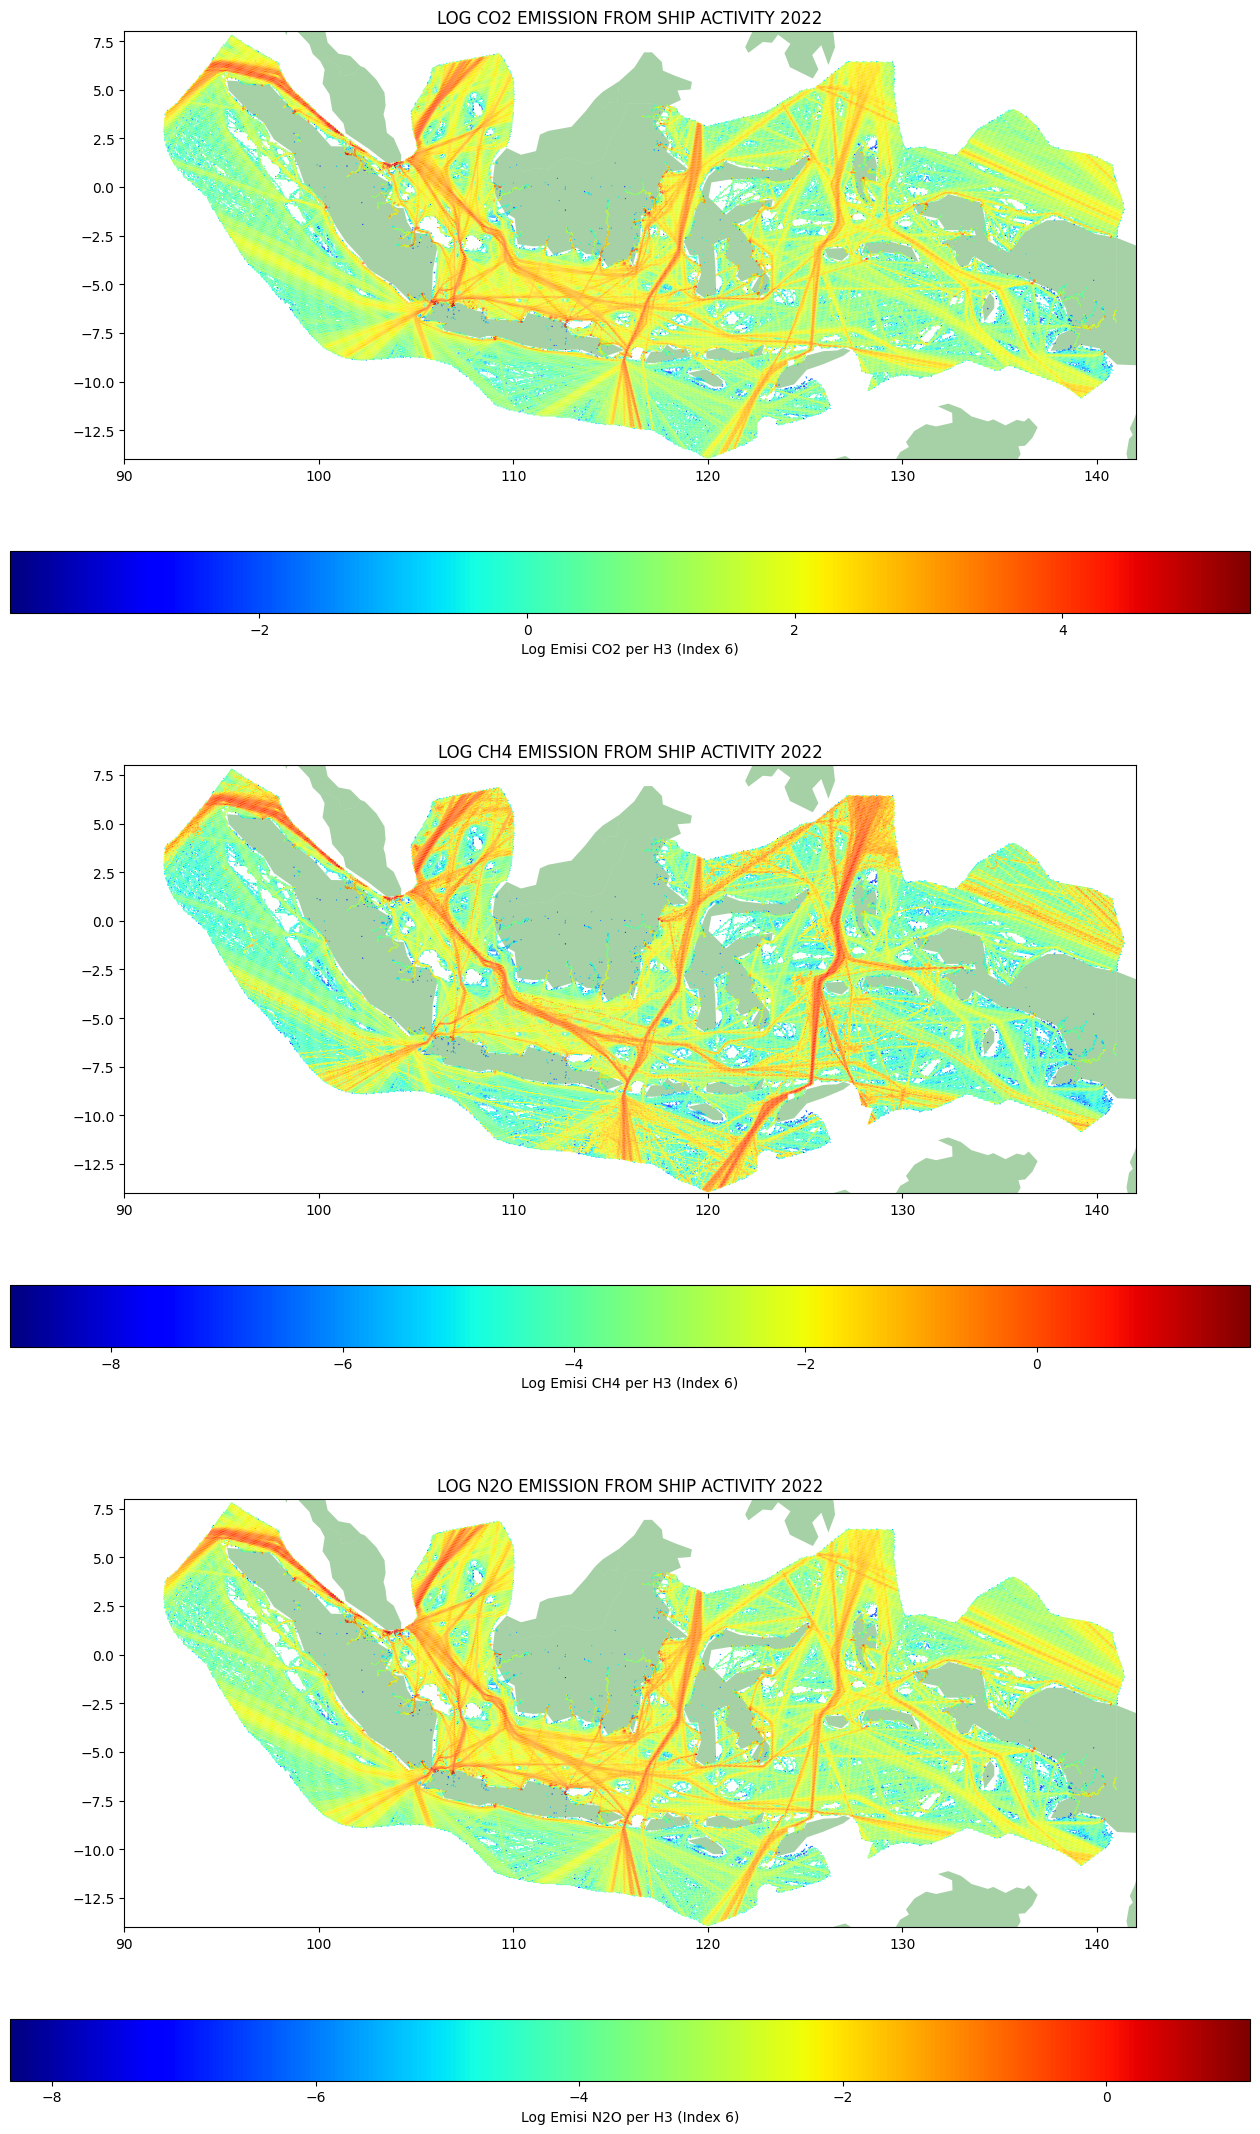

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(3,1,figsize=(16,27))

cmap = mpl.cm.jet
countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

df_plot1 = df_plot[df_plot["newres"] == "Nonresiden Inside"]

df_plot1 = df_plot1.assign(hex_id=df_plot1.H3_int_index_6.apply(lambda x: h3.h3_to_string(x)))
geom_h3=[]
for ind, row in df_plot.iterrows():
    geom=Polygon(h3.h3_to_geo_boundary(row["hex_id"], geo_json=True))
    geom_h3.append(geom)

df_plot1 = df_plot1.assign(geometry=geom_h3)
df_plot1 = gpd.GeoDataFrame(df_plot1,geometry="geometry")

countries.plot(ax=ax1, alpha=0.4, color="forestgreen")
df_plot1.plot(ax=ax1,column='log_totalEmission',cmap=cmap, legend=True, legend_kwds = {'label': "Log Total Emisi CO2 per H3 (Index 6)", "orientation": "horizontal"})

ax1.set_xlim(90, 142)
ax1.set_ylim(-14, 8)

# chart formatting
ax1.set_title("LOG CO2 EMISSION FROM SHIP ACTIVITY 2022")
ax1.set_xlabel("")

## Emission per Month and Per Resident Type only on ISIC 501

In [ ]:
##Transform grams to tonnes
df = df.withColumn("date_pos",F.to_date("dt_pos_utc"))
df = df.where(df.date_pos > "2020-12-31")
df = df.withColumn('month_pos', F.month(df['date_pos']))

In [ ]:
vessel_co2=df.select("month_pos", "co2_t", "newres")\
                .filter(~((F.isnan(F.col("co2_t")))|(F.col("co2_t").isNull())))\
                .groupby("month_pos", "newres")\
                .agg({"co2_t":"sum"})
vessel_co2.show(36)

+---------+-----------------+------------------+
|month_pos|           newres|        sum(co2_t)|
+---------+-----------------+------------------+
|        3|  Residen Outside|236396.84849766456|
|       12|  Residen Outside|255363.85257379315|
|        5|  Residen Outside|244177.19017359536|
|        8|  Residen Outside|229882.36247376443|
|        9|  Residen Outside|220847.60459994795|
|        2|  Residen Outside|217269.17885203744|
|       11|  Residen Outside|233562.61519484496|
|        4|  Residen Outside|226176.39511870613|
|       10|  Residen Outside|213823.75237142816|
|        1|  Residen Outside|219436.36198160108|
|        6|  Residen Outside|240025.16093048838|
|        7|  Residen Outside|236351.75416955774|
|        6|Nonresiden Inside|2202862.8326522782|
|        7|Nonresiden Inside|2209735.9593126946|
|        4|Nonresiden Inside|2287970.6972777345|
|       12|Nonresiden Inside| 2442441.100478239|
|        8|Nonresiden Inside|2199760.6856897804|
|        1|Nonreside

In [ ]:
vessel_n2o=df.select("month_pos", "n2o_t", "newres")\
                .filter(~((F.isnan(F.col("n2o_t")))|(F.col("n2o_t").isNull())))\
                .groupby("month_pos", "newres")\
                .agg({"n2o_t":"sum"})
vessel_n2o.show(36)

+---------+-----------------+------------------+
|month_pos|           newres|        sum(n2o_t)|
+---------+-----------------+------------------+
|        3|  Residen Outside|12.529860278048535|
|        6|Nonresiden Inside|117.59458831831024|
|        6|   Residen Inside|  23.3289737913397|
|        7|Nonresiden Inside|117.65606148320485|
|       12|Nonresiden Inside|130.26441688371568|
|        4|Nonresiden Inside|121.61260967300078|
|       11|   Residen Inside|26.223668180170108|
|        1|   Residen Inside| 22.90992339115553|
|       12|  Residen Outside|13.612777909005642|
|       10|   Residen Inside|22.979112005143456|
|        8|Nonresiden Inside|117.42380905458954|
|        5|  Residen Outside|12.934544491724306|
|        1|Nonresiden Inside|121.33235435903117|
|        5|Nonresiden Inside|125.21846331204569|
|       10|Nonresiden Inside|120.22389123940371|
|        4|   Residen Inside|23.118507412847457|
|        8|   Residen Inside|22.791247732459567|
|        8|  Residen

In [ ]:
vessel_ch4=df.select("month_pos", "ch4_t", "newres")\
                .filter(~((F.isnan(F.col("ch4_t")))|(F.col("ch4_t").isNull())))\
                .groupby("month_pos", "newres")\
                .agg({"ch4_t":"sum"})
vessel_ch4.show(36)

+---------+-----------------+------------------+
|month_pos|           newres|        sum(ch4_t)|
+---------+-----------------+------------------+
|        3|  Residen Outside| 7.291982308141271|
|        6|Nonresiden Inside| 527.7698813668518|
|        6|   Residen Inside| 8.113901670880526|
|        7|Nonresiden Inside| 692.3243459846946|
|        4|Nonresiden Inside| 703.5473288168376|
|       12|Nonresiden Inside| 781.2530722778845|
|       11|   Residen Inside| 22.40808155423743|
|        1|   Residen Inside|12.759153622131201|
|       12|  Residen Outside|  15.0078794890576|
|       10|   Residen Inside|  8.85703803148667|
|        8|Nonresiden Inside| 698.7075381658598|
|        5|  Residen Outside| 4.756593584570743|
|        1|Nonresiden Inside| 571.9517496498962|
|        5|Nonresiden Inside| 775.2626665097943|
|       10|Nonresiden Inside| 761.1030866333489|
|        4|   Residen Inside|13.503818435638374|
|        8|   Residen Inside| 8.232031283773683|
|        8|  Residen

In [ ]:
#jumlah kapal perbulan
#jumlah kapal
vessel_count = df.select("month_pos", "imo", "newres") \
    .filter(F.col("imo").isNotNull()) \
    .groupBy("month_pos", "newres") \
    .agg(F.countDistinct("imo").alias("unique_vessels"))

In [ ]:
vessel_count.show(36)

+---------+-----------------+--------------+
|month_pos|           newres|unique_vessels|
+---------+-----------------+--------------+
|        3|  Residen Outside|           414|
|        6|Nonresiden Inside|          7598|
|        6|   Residen Inside|          1310|
|        7|Nonresiden Inside|          7597|
|        4|Nonresiden Inside|          7566|
|       12|Nonresiden Inside|          7608|
|       11|   Residen Inside|          1431|
|        1|   Residen Inside|          1301|
|       12|  Residen Outside|           459|
|       10|   Residen Inside|          1304|
|        8|Nonresiden Inside|          7460|
|        5|  Residen Outside|           404|
|        1|Nonresiden Inside|          7730|
|        5|Nonresiden Inside|          7664|
|       10|Nonresiden Inside|          7549|
|        4|   Residen Inside|          1316|
|        8|   Residen Inside|          1290|
|        8|  Residen Outside|           387|
|        9|  Residen Outside|           398|
|        9

### Stop Sesi Spark

In [ ]:
spark.stop()